## Блокнот организован по методологии CRISP-DM :
- 0. Preparation
- 1. Business Understanding
- 2. Data Understanding
- 3. Data Preparation
- 4. Modeling
- 5. Evaluation

---
# 0. Preparation
Импорт необходимых библиотек

In [1]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as grd
import seaborn as sns
import numpy as np
import pandas as pd
import glob
import xgboost as xgb
import warnings
from time import time

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

In [2]:
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)

warnings.filterwarnings('ignore')

----
# 1. Business Understanding
- На сколько хорошо модели машинного обучения смогут предсказывать результаты теннисных матчей 

----
# 2. Data Understanding

## 2.1 ATP Matches

In [3]:
# Загрузка данных
filename_atp = 'data/atp/atp_matches_2018.csv'
atp_2018_raw_df = pd.read_csv(filename_atp)

print('Shape of atp_2018_raw_df: {}'.format(atp_2018_raw_df.shape))
atp_2018_raw_df.head()

Shape of atp_2018_raw_df: (2889, 49)


,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,loser_id,loser_seed,loser_entry,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,score,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
0,2018-M020,Brisbane,Hard,NaN,A,20180101,271,105992,NaN,NaN,Ryan Harrison,R,183.0,USA,25.65,104919,NaN,NaN,Leonardo Mayer,R,188.0,ARG,30.63,6-4 3-6 6-2,3,R32,123.0,9.0,2.0,82.0,49.0,39.0,20.0,13.0,8.0,9.0,10.0,3.0,80.0,47.0,33.0,19.0,14.0,1.0,4.0,47.0,1010.0,52.0,909.0
1,2018-M020,Brisbane,Hard,NaN,A,20180101,272,111577,NaN,NaN,Jared Donaldson,R,NaN,USA,21.23,111442,NaN,WC,Jordan Thompson,R,NaN,AUS,23.70,6-2 6-4,3,R32,90.0,5.0,3.0,58.0,32.0,25.0,14.0,9.0,4.0,5.0,3.0,5.0,62.0,41.0,25.0,7.0,9.0,7.0,11.0,54.0,890.0,94.0,593.0
2,2018-M020,Brisbane,Hard,NaN,A,20180101,273,104797,NaN,NaN,Denis Istomin,R,188.0,UZB,31.32,106000,7.0,NaN,Damir Dzumhur,R,172.0,BIH,25.62,6-7(4) 6-3 6-2,3,R32,145.0,7.0,0.0,94.0,66.0,48.0,12.0,14.0,9.0,11.0,8.0,6.0,120.0,53.0,37.0,29.0,15.0,10.0,16.0,63.0,809.0,30.0,1391.0
3,2018-M020,Brisbane,Hard,NaN,A,20180101,275,200282,NaN,WC,Alex De Minaur,R,NaN,AUS,18.87,105449,NaN,NaN,Steve Johnson,R,188.0,USA,28.02,7-6(7) 6-4,3,R32,104.0,9.0,3.0,66.0,37.0,32.0,17.0,11.0,2.0,3.0,6.0,2.0,80.0,43.0,33.0,17.0,11.0,4.0,6.0,208.0,245.0,44.0,1055.0
4,2018-M020,Brisbane,Hard,NaN,A,20180101,276,111581,NaN,Q,Michael Mmoh,R,NaN,USA,19.98,105643,NaN,NaN,Federico Delbonis,L,190.0,ARG,27.24,6-3 6-4,3,R32,69.0,5.0,4.0,55.0,38.0,32.0,11.0,10.0,3.0,3.0,4.0,0.0,45.0,35.0,28.0,5.0,9.0,0.0,2.0,175.0,299.0,68.0,755.0


In [4]:
atp_2018_raw_df.describe()

,draw_size,tourney_date,match_num,winner_id,winner_seed,winner_ht,winner_age,loser_id,loser_seed,loser_ht,loser_age,best_of,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
count,0.0,2.889000e+03,2889.000000,2889.000000,1140.000000,1909.000000,2889.000000,2889.000000,711.000000,1729.000000,2886.000000,2889.000000,2854.000000,2863.000000,2863.000000,2863.000000,2863.000000,2863.000000,2863.000000,2863.000000,2863.000000,2863.000000,2863.000000,2863.000000,2863.000000,2863.000000,2863.000000,2863.000000,2863.000000,2863.000000,2863.000000,2882.000000,2882.000000,2858.000000,2858.000000
mean,NaN,2.018055e+07,238.570440,109961.685012,7.550877,187.062336,27.603337,111619.027691,8.652602,186.153846,27.570035,3.391139,110.647863,7.491792,2.825707,79.852951,49.532658,37.754803,16.777506,12.880545,3.449528,4.993014,5.706951,3.507510,83.035278,50.209570,34.001397,15.258121,12.643730,4.786587,8.501572,82.605482,1658.567661,113.144157,1073.077327
std,NaN,2.949893e+02,87.221484,15430.662041,7.210375,7.936316,4.676315,18694.622174,7.342064,7.412650,4.722971,0.793414,42.114631,5.987337,2.380038,29.397889,19.209124,14.113693,6.807200,4.368073,2.971355,3.922460,5.357490,2.570433,29.433158,19.308108,14.720575,7.123407,4.340448,3.301875,4.172710,154.145343,1793.770366,184.283540,1051.781776
min,NaN,2.018010e+07,1.000000,100644.000000,1.000000,163.000000,14.940000,100644.000000,1.000000,163.000000,14.530000,3.000000,15.000000,0.000000,0.000000,9.000000,5.000000,4.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,11.000000,6.000000,1.000000,1.000000,2.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,NaN,2.018030e+07,219.000000,104898.000000,2.000000,183.000000,23.590000,104926.000000,4.000000,183.000000,23.882500,3.000000,79.000000,3.000000,1.000000,58.000000,36.000000,28.000000,12.000000,10.000000,1.000000,2.000000,2.000000,2.000000,61.000000,36.000000,23.000000,10.000000,9.000000,2.000000,5.000000,20.000000,656.500000,36.000000,507.500000
50%,NaN,2.018053e+07,277.000000,105526.000000,5.000000,185.000000,27.990000,105583.000000,6.000000,185.000000,27.780000,3.000000,103.000000,6.000000,2.000000,75.000000,46.000000,35.000000,16.000000,12.000000,3.000000,4.000000,4.000000,3.000000,78.000000,47.000000,32.000000,14.000000,12.000000,4.000000,8.000000,48.000000,1020.000000,68.000000,805.000000
75%,NaN,2.018081e+07,290.000000,106329.000000,9.000000,190.000000,31.110000,106378.000000,11.000000,190.000000,30.870000,3.000000,135.000000,10.000000,4.000000,96.000000,60.000000,45.000000,21.000000,15.000000,5.000000,7.000000,8.000000,5.000000,100.000000,61.000000,42.000000,19.000000,15.000000,7.000000,11.000000,87.750000,1848.750000,111.000000,1249.500000
max,NaN,2.018112e+07,701.000000,208029.000000,32.000000,208.000000,39.380000,207973.000000,32.000000,208.000000,39.420000,5.000000,396.000000,64.000000,16.000000,278.000000,198.000000,166.000000,56.000000,49.000000,19.000000,25.000000,61.000000,18.000000,291.000000,218.000000,171.000000,50.000000,50.000000,22.000000,28.000000,1821.000000,10600.000000,1821.000000,10600.000000


In [5]:
# исключаем нестандартные типы турниров и оставляем колонки, которые нам нужны 
columns = ['tourney_id', 'match_num', 'winner_rank', 'loser_rank']
atp_2018_df = atp_2018_raw_df[columns][~atp_2018_raw_df['tourney_level'].isin(['D', 'F'])] #Davis Cup & ATP Finals

print('Shape of atp_2018_df: {}'.format(atp_2018_df.shape))
atp_2018_df.head()

Shape of atp_2018_df: (2622, 4)


,tourney_id,match_num,winner_rank,loser_rank
0,2018-M020,271,47.0,52.0
1,2018-M020,272,54.0,94.0
2,2018-M020,273,63.0,30.0
3,2018-M020,275,208.0,44.0
4,2018-M020,276,175.0,68.0


In [6]:
# пропущенные значения 
print(atp_2018_df.isna().sum())

tourney_id     0
match_num      0
winner_rank    0
loser_rank     3
dtype: int64


In [7]:
# строки с пропущенными значениями 
atp_2018_raw_df[(~atp_2018_raw_df['tourney_level'].isin(['D', 'F'])) & atp_2018_raw_df['loser_rank'].isna()] 

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,loser_id,loser_seed,loser_entry,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,score,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
32,2018-0451,Doha,Hard,NaN,A,20180101,275,105882,NaN,Q,Stefano Travaglia,U,NaN,ITA,26.04,106325,NaN,WC,Jabor Al Mutawa,U,NaN,QAT,23.62,6-1 6-2,3,R32,53.0,8.0,2.0,34.0,20.0,19.0,9.0,7.0,0.0,0.0,0.0,2.0,50.0,40.0,19.0,3.0,8.0,4.0,9.0,134.0,414.0,NaN,NaN
91,2018-0301,Auckland,Hard,NaN,A,20180108,278,105138,5.0,NaN,Roberto Bautista Agut,R,183.0,ESP,29.74,105030,NaN,WC,Michael Venus,R,NaN,NZL,30.23,6-2 6-1,3,R32,56.0,3.0,1.0,51.0,37.0,29.0,7.0,8.0,5.0,6.0,3.0,3.0,42.0,18.0,11.0,4.0,7.0,2.0,7.0,21.0,1855.0,NaN,NaN
442,2018-7434,Sofia,Hard,NaN,A,20180205,283,104797,NaN,NaN,Denis Istomin,R,188.0,UZB,31.41,202090,NaN,WC,Adrian Andreev,U,NaN,BUL,16.74,6-3 6-4,3,R32,78.0,3.0,0.0,56.0,36.0,27.0,9.0,10.0,1.0,4.0,1.0,3.0,58.0,39.0,18.0,10.0,9.0,4.0,9.0,74.0,713.0,NaN,NaN


худшие игроки ATP имеют ранг чуть меньше чем 2000, заменим пропущенные значения на 2000

---
## 2.2 All ATP Data

### 2.3.1 Load Data

In [8]:
# чтение файлов 
filepath = 'data/atp/'
filenames = glob.glob(filepath + '*.csv')
li = []

for filename in filenames:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

df = pd.concat(li, axis=0, ignore_index=True)

In [9]:
print('Shape of df: {}'.format(df.shape))
df.head()

Shape of df: (176572, 49)


,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,loser_id,loser_seed,loser_entry,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,score,best_of,round,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
0,2000-339,Adelaide,Hard,NaN,A,20000103,1,102358,1.0,NaN,Thomas Enqvist,R,190.0,SWE,25.81,103096,NaN,NaN,Arnaud Clement,R,173.0,FRA,22.05,6-3 6-4,3,R32,76.0,6.0,0.0,66.0,29.0,23.0,23.0,10.0,2.0,2.0,1.0,3.0,59.0,37.0,25.0,13.0,9.0,2.0,4.0,4.0,1850.0,56.0,490.0
1,2000-339,Adelaide,Hard,NaN,A,20000103,2,103819,NaN,NaN,Roger Federer,R,185.0,SUI,18.40,102533,NaN,NaN,Jens Knippschild,R,190.0,GER,24.88,6-1 6-4,3,R32,45.0,6.0,3.0,46.0,28.0,24.0,12.0,9.0,0.0,0.0,3.0,5.0,42.0,15.0,13.0,12.0,8.0,0.0,3.0,64.0,515.0,91.0,404.0
2,2000-339,Adelaide,Hard,NaN,A,20000103,3,102998,NaN,NaN,Jan Michael Gambill,R,190.0,USA,22.58,101885,NaN,NaN,Wayne Arthurs,L,190.0,AUS,28.80,3-6 7-6(5) 6-4,3,R32,115.0,8.0,3.0,81.0,40.0,35.0,28.0,15.0,0.0,1.0,26.0,2.0,103.0,59.0,49.0,22.0,16.0,4.0,5.0,58.0,544.0,105.0,243.0
3,2000-339,Adelaide,Hard,NaN,A,20000103,4,103206,7.0,NaN,Sebastien Grosjean,R,175.0,FRA,21.60,102776,NaN,NaN,Andrew Ilie,R,180.0,AUS,23.71,6-2 6-1,3,R32,65.0,4.0,2.0,66.0,35.0,28.0,14.0,7.0,4.0,4.0,0.0,3.0,49.0,22.0,12.0,8.0,8.0,1.0,6.0,27.0,928.0,54.0,602.0
4,2000-339,Adelaide,Hard,NaN,A,20000103,5,102796,3.0,NaN,Magnus Norman,R,188.0,SWE,23.59,102401,NaN,WC,Scott Draper,L,178.0,AUS,25.58,6-4 6-4,3,R32,68.0,6.0,2.0,52.0,32.0,26.0,12.0,10.0,0.0,1.0,4.0,2.0,73.0,40.0,25.0,16.0,10.0,7.0,10.0,15.0,1244.0,154.0,219.0


In [10]:
df.describe()

,draw_size,tourney_date,match_num,winner_id,winner_seed,winner_ht,winner_age,loser_id,loser_seed,loser_ht,loser_age,best_of,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
count,0.0,1.765720e+05,176572.000000,176572.000000,75164.000000,132525.000000,176542.000000,176572.000000,41381.000000,115595.000000,176185.000000,176572.000000,112954.000000,117081.000000,117081.000000,117081.00000,117081.000000,117081.000000,117081.000000,117081.000000,117081.000000,117081.000000,117081.000000,117081.000000,117081.000000,117081.000000,117081.000000,117081.000000,117081.000000,117081.000000,117081.000000,175117.000000,175117.000000,170789.000000,170789.000000
mean,NaN,2.009890e+07,137.569603,105835.891970,5.636741,184.896065,25.593767,106740.809981,6.430101,184.676162,25.356508,3.158632,98.597323,5.822414,2.614147,72.71372,44.611833,33.389278,15.514900,11.604872,3.342336,4.912548,4.271786,3.405096,75.550405,45.117372,29.497963,13.793997,11.427772,4.589242,8.452353,197.755381,690.971990,269.024925,447.837308
std,NaN,5.429129e+04,218.156142,8992.519225,5.086880,6.744445,3.836250,11851.891922,5.474779,6.662957,3.997997,0.540464,39.902990,4.987832,2.229551,26.06097,16.905193,11.905547,6.384606,3.680256,2.955902,3.870466,4.221294,2.475962,25.786734,17.070361,12.855240,6.669343,3.686145,3.111074,3.827974,200.792903,1294.134856,288.477736,717.630473
min,NaN,2.000010e+07,1.000000,100415.000000,1.000000,145.000000,14.800000,100415.000000,1.000000,145.000000,14.080000,3.000000,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,NaN,2.005111e+07,12.000000,103580.000000,2.000000,180.000000,22.730000,103581.000000,3.000000,180.000000,22.420000,3.000000,72.000000,2.000000,1.000000,54.00000,32.000000,25.000000,11.000000,9.000000,1.000000,2.000000,1.000000,2.000000,57.000000,33.000000,20.000000,9.000000,9.000000,2.000000,6.000000,73.000000,168.000000,94.000000,122.000000
50%,NaN,2.010063e+07,24.000000,104386.000000,5.000000,185.000000,25.380000,104474.000000,5.000000,185.000000,25.160000,3.000000,92.000000,5.000000,2.000000,68.00000,42.000000,31.000000,15.000000,11.000000,3.000000,4.000000,3.000000,3.000000,71.000000,42.000000,28.000000,13.000000,10.000000,4.000000,8.000000,150.000000,331.000000,189.000000,247.000000
75%,NaN,2.015031e+07,247.000000,105226.000000,7.000000,188.000000,28.170000,105438.000000,8.000000,188.000000,28.030000,3.000000,120.000000,8.000000,4.000000,89.00000,54.000000,40.000000,19.000000,14.000000,5.000000,7.000000,6.000000,5.000000,91.000000,55.000000,37.000000,18.000000,14.000000,6.000000,11.000000,255.000000,650.000000,321.000000,524.000000
max,NaN,2.018112e+07,946.000000,208279.000000,35.000000,208.000000,58.360000,208279.000000,35.000000,208.000000,60.170000,5.000000,4756.000000,412.000000,23.000000,491.00000,361.000000,292.000000,82.000000,90.000000,24.000000,30.000000,103.000000,25.000000,489.000000,328.000000,284.000000,101.000000,91.000000,25.000000,34.000000,2220.000000,16950.000000,2257.000000,16950.000000


### 2.3.2 Analyse surface
Все строки с None это кубок Девиса , которые будут отфильтрованы 

In [11]:
df.groupby('surface').size()

surface
Carpet     6120
Clay      72289
Grass     10373
Hard      87592
None         80
dtype: int64

In [12]:
# посмотрим на некоторые из них 
df[df['surface'] == 'None'].groupby('tourney_name', as_index=False).size().head()

,tourney_name,size
0,Davis Cup G1 R1: ISR vs POR,4
1,Davis Cup G1 R1: NZL vs IND,4
2,Davis Cup G1 R1: PER vs ECU,4
3,Davis Cup G1 R1: ROU vs BLR,4
4,Davis Cup G1 R1: TPE vs CHN,4


### 2.3.3 Analyse tourney_level
- **A**: All normal tournaments as ATP250 and ATP500 including qualification. Olympics are in this category as well but will be filtered out
- **C**: Challenger tournaments
- **D**: Davis Cup matches
- **F**: Masters and Next Gen Finals
- **G**: Grand Slam tournaments
- **M**: ATP Masters 1000 tournaments

In [13]:
# распределение значений 
df.groupby('tourney_level').size()

tourney_level
A    43601
C    99088
D     5888
F      271
G    14580
M    13144
dtype: int64

In [14]:
# посмотрим на примеры 
df[df['tourney_level'] == 'M'].groupby('tourney_name').size()

tourney_name
Canada Masters          1322
Cincinnati Masters      1335
Hamburg Masters          593
Indian Wells Masters    2037
Madrid Masters          1104
Miami Masters           2201
Monte Carlo Masters     1335
Paris Masters           1073
Rome Masters            1311
Shanghai Masters         739
Stuttgart Masters         94
dtype: int64

### 2.3.4 Analyse round
- **BR**: Bronze medal match in Olympics and Next Gen Finals
- **F**: Final
- **Q1**: Qualification round 1
- **Q2**: Qualification round 2
- **Q3**: Qualification round 3
- **QF**: Quarter-final
- **R128**: Round of 128
- **R16**: Round of 16
- **R32**: Round of 32
- **R64**: Round of 64
- **RR**: Round robin. All player meet each other in group.
- **SF**: Semi-final

In [15]:
# распределение значений 
df.groupby('round').size()

round
BR          7
F        4151
Q1      15753
Q2       9359
Q3       3790
QF      16431
R128     5952
R16     32828
R32     64499
R64      9008
RR       6530
SF       8264
dtype: int64

In [16]:
# некоторые примеры 
df[df['round'] == 'BR'].groupby('tourney_name', as_index=False).size().head(7)

,tourney_name,size
0,Athens Olympics,1
1,Beijing Olympics,1
2,London Olympics,1
3,Next Gen Finals,2
4,Rio Olympics,1
5,Sydney Olympics,1


### 2.3.5 Analyse tourney_id
Идентификатор турнира индивидуален для каждого турнира и года. Первая часть идентификатора - это год, а затем идентификатор турнира, который сохраняется во времени.


In [17]:
# турнир может менять название , посмотрим сохраняется ли id 
df[df['tourney_name'].isin(['Aix En Provence CH', 'Aix en Provence CH'])].groupby(['tourney_name', 'tourney_id']).size()

tourney_name        tourney_id
Aix En Provence CH  2003-1685     31
                    2004-1685     31
                    2017-7009     54
                    2018-7009     56
Aix en Provence CH  2014-7009     31
                    2015-7009     31
                    2016-7009     49
dtype: int64

----
# 3. Data Preparation

## 3.1 ATP Matches

In [18]:
# Заполняем пропущенные значения 
atp_2018_df['loser_rank'].fillna(2000, inplace=True)

# проверка
print(atp_2018_df.isna().sum())

tourney_id     0
match_num      0
winner_rank    0
loser_rank     0
dtype: int64


## 3.2 All ATP Data

### 3.3.1 Filter Rows to Use
Исключаем некоторые турниры и типы турниров, которые отличаются от обычного формата.

In [19]:
main_df = df[~df['tourney_level'].isin(['D', 'F'])] #Davis Cup & ATP Finals
main_df = main_df[~main_df['tourney_id'].isin(['2008-96', '2012-96', '2016-O16', '2017-7696'])] #Olympics
main_df = main_df[~main_df['tourney_id'].str.split(pat='-').str.get(1).isin(['6406', '0605', '615', '433', '506', '499', '339', '96'])] #Challenger tour final + various RR tournaments


print('Shape of main_df: {}'.format(main_df.shape))

Shape of main_df: (167244, 49)


### 3.3.2 Add and Modify Columns
Создадим новые колонки на основе текущих 

#### 3.3.2.1 tourney_id_per
создадим индентификатор турнира который будет постоянный во времени

In [20]:
main_df['tourney_id_per'] = main_df['tourney_id'].str.split(pat='-').str.get(1)


main_df.groupby('tourney_id_per').size().head()

tourney_id_per
0083    167
0091    169
0213    151
0221    154
0228    160
dtype: int64

#### 3.3.2.2 tourney_year
возьмём год турнира и поместим в отдельную колонку 

In [21]:
# понадобиться для фильтрации в дальнейшем 
main_df['tourney_year'] = main_df['tourney_id'].str.split(pat='-').str.get(0).astype(int)


main_df.groupby('tourney_year').size()

tourney_year
2000     6606
2001     7009
2002     6433
2003     6907
2004     7264
2005     7420
2006     7761
2007     9674
2008     9651
2009     9348
2010     9090
2011     8839
2012     8826
2013     8892
2014     8847
2015     9227
2016    12457
2017    10451
2018    12542
dtype: int64

#### 3.3.2.3 round
переведём раунд в инты 

In [22]:
round_dict = {'Q1': 1,
              'Q2': 2,
              'Q3': 3,
              'R128': 4,
              'R64': 5,
              'R32': 6,
              'R16': 7,
              'QF': 8,
              'SF': 9,
              'F': 10} 
main_df['round'].replace(round_dict, inplace=True)

# проверим новые значения раунда 
main_df.groupby('round').size()

round
1     15344
2      9143
3      3690
4      5952
5      8848
6     63571
7     32372
8     16187
9      8092
10     4045
dtype: int64

In [23]:
# посмотрим на примеры 
main_df[main_df['round'] == 10].head()

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,loser_id,loser_seed,loser_entry,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,score,best_of,...,minutes,w_ace,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,tourney_id_per,tourney_year
61,2000-891,Chennai,Hard,NaN,A,20000103,31,102259,4.0,NaN,Jerome Golmard,L,188.0,FRA,26.32,103082,NaN,NaN,Markus Hantschk,R,188.0,GER,22.12,6-3 6-7(6) 6-3,3,...,148.0,8.0,1.0,88.0,65.0,49.0,13.0,14.0,2.0,3.0,10.0,4.0,123.0,74.0,53.0,18.0,16.0,9.0,14.0,35.0,666.0,128.0,273.0,891,2000
92,2000-451,Doha,Hard,NaN,A,20000103,31,102148,3.0,NaN,Fabrice Santoro,R,178.0,FRA,27.07,102783,NaN,NaN,Rainer Schuettler,R,180.0,GER,23.69,3-6 7-5 3-0 RET,3,...,118.0,3.0,0.0,74.0,44.0,27.0,16.0,12.0,2.0,6.0,1.0,1.0,85.0,61.0,33.0,12.0,13.0,7.0,12.0,34.0,764.0,48.0,579.0,451,2000
123,2000-301,Auckland,Hard,NaN,A,20000110,31,102796,2.0,NaN,Magnus Norman,R,188.0,SWE,23.61,102021,NaN,NaN,Michael Chang,R,175.0,USA,27.88,3-6 6-3 7-5,3,...,140.0,6.0,8.0,87.0,50.0,41.0,12.0,15.0,3.0,7.0,3.0,4.0,102.0,54.0,38.0,18.0,15.0,5.0,10.0,14.0,1498.0,50.0,722.0,301,2000
154,2000-338,Sydney,Hard,NaN,A,20000110,31,103720,NaN,NaN,Lleyton Hewitt,R,180.0,AUS,18.87,101727,NaN,WC,Jason Stoltenberg,R,185.0,AUS,29.77,6-4 6-0,3,...,57.0,2.0,4.0,41.0,29.0,25.0,5.0,8.0,0.0,1.0,2.0,3.0,46.0,21.0,13.0,8.0,8.0,1.0,6.0,21.0,1232.0,94.0,419.0,338,2000
281,2000-580,Australian Open,Hard,NaN,G,20000117,127,101736,1.0,NaN,Andre Agassi,R,180.0,USA,29.72,102338,2.0,NaN,Yevgeny Kafelnikov,R,190.0,RUS,25.91,3-6 6-3 6-2 6-4,5,...,139.0,9.0,5.0,116.0,77.0,52.0,23.0,18.0,4.0,7.0,14.0,9.0,122.0,65.0,42.0,30.0,18.0,11.0,17.0,1.0,4135.0,2.0,2915.0,580,2000


#### 3.3.2.4 hth_id
нужны два типа идентификаторов для очной встречи : 
- Так как игрок A против игрока B, это то же самое, что игрок B против игрока A, мы создаем идентификатор, который всегда будет иметь игрока с наименьшим рангом первым . 
- Затем у нас есть идентификатор, специфичный для матча, который создается с использованием сначала Win_id, а затем loser_id.нужно для присоединения фич связанных с очной встречей к парвильному матчу 

In [24]:
# добавляем идентификатор для очной встречи 
main_df['hth_id'] = np.where(main_df['winner_id'] < main_df['loser_id'], 
                          main_df['winner_id'].map(str) + '_' + main_df['loser_id'].map(str), 
                          main_df['loser_id'].map(str) + '_' + main_df['winner_id'].map(str))

# добавляем идентификатор для матча 
main_df['hth_id_match'] = main_df['winner_id'].map(str) + '_' + main_df['loser_id'].map(str)

# примеры 
main_df.head()

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,winner_name,winner_hand,winner_ht,winner_ioc,winner_age,loser_id,loser_seed,loser_entry,loser_name,loser_hand,loser_ht,loser_ioc,loser_age,score,best_of,...,w_df,w_svpt,w_1stIn,w_1stWon,w_2ndWon,w_SvGms,w_bpSaved,w_bpFaced,l_ace,l_df,l_svpt,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points,tourney_id_per,tourney_year,hth_id,hth_id_match
31,2000-891,Chennai,Hard,NaN,A,20000103,1,103420,NaN,NaN,Michal Tabara,R,175.0,CZE,20.40,102338,1.0,NaN,Yevgeny Kafelnikov,R,190.0,RUS,25.87,6-4 6-2,3,...,1.0,57.0,37.0,25.0,12.0,9.0,2.0,3.0,4.0,5.0,57.0,23.0,16.0,13.0,9.0,3.0,7.0,123.0,339.0,2.0,2733.0,891,2000,102338_103420,103420_102338
32,2000-891,Chennai,Hard,NaN,A,20000103,2,102455,NaN,NaN,Lorenzo Manta,R,190.0,SUI,25.30,102720,NaN,NaN,Tomas Zib,R,178.0,CZE,23.92,7-5 6-2,3,...,1.0,69.0,42.0,31.0,16.0,10.0,4.0,4.0,4.0,2.0,70.0,50.0,31.0,9.0,10.0,5.0,8.0,115.0,230.0,111.0,323.0,891,2000,102455_102720,102455_102720
33,2000-891,Chennai,Hard,NaN,A,20000103,3,102093,NaN,NaN,Martin Damm,R,188.0,CZE,27.42,103294,NaN,NaN,Christophe Rochus,R,170.0,BEL,21.05,6-3 6-0,3,...,0.0,46.0,26.0,23.0,12.0,8.0,1.0,1.0,1.0,1.0,37.0,17.0,8.0,9.0,7.0,1.0,5.0,104.0,296.0,121.0,293.0,891,2000,102093_103294,102093_103294
34,2000-891,Chennai,Hard,NaN,A,20000103,4,101086,7.0,NaN,Ronald Agenor,R,180.0,USA,35.14,104156,NaN,WC,Sunil Kumar,R,NaN,IND,16.75,6-4 6-4,3,...,0.0,64.0,35.0,26.0,19.0,10.0,2.0,3.0,2.0,3.0,62.0,32.0,22.0,16.0,10.0,1.0,4.0,96.0,416.0,1199.0,3.0,891,2000,101086_104156,101086_104156
35,2000-891,Chennai,Hard,NaN,A,20000103,5,102259,4.0,NaN,Jerome Golmard,L,188.0,FRA,26.32,102689,NaN,Q,Martin Spottl,R,180.0,AUT,24.11,6-3 6-4,3,...,2.0,65.0,43.0,33.0,14.0,10.0,4.0,4.0,6.0,2.0,61.0,21.0,14.0,23.0,9.0,2.0,4.0,35.0,666.0,201.0,191.0,891,2000,102259_102689,102259_102689


### 3.3.3 Filter Columns to Use
фильтрация колонок, которые будут использоваться далее 

In [25]:
main_df = main_df[['tourney_id', 'tourney_id_per', 'tourney_year', 'tourney_date', 'match_num', 'surface', 'tourney_level', 
                   'round', 'hth_id', 'hth_id_match', 'winner_id', 'loser_id', 'winner_rank', 'loser_rank', 'winner_age', 
                   'loser_age', 'winner_ht', 'loser_ht']].copy()


print('Shape of main_df: {}'.format(main_df.shape))
main_df.head()

Shape of main_df: (167244, 18)


,tourney_id,tourney_id_per,tourney_year,tourney_date,match_num,surface,tourney_level,round,hth_id,hth_id_match,winner_id,loser_id,winner_rank,loser_rank,winner_age,loser_age,winner_ht,loser_ht
31,2000-891,891,2000,20000103,1,Hard,A,6,102338_103420,103420_102338,103420,102338,123.0,2.0,20.40,25.87,175.0,190.0
32,2000-891,891,2000,20000103,2,Hard,A,6,102455_102720,102455_102720,102455,102720,115.0,111.0,25.30,23.92,190.0,178.0
33,2000-891,891,2000,20000103,3,Hard,A,6,102093_103294,102093_103294,102093,103294,104.0,121.0,27.42,21.05,188.0,170.0
34,2000-891,891,2000,20000103,4,Hard,A,6,101086_104156,101086_104156,101086,104156,96.0,1199.0,35.14,16.75,180.0,NaN
35,2000-891,891,2000,20000103,5,Hard,A,6,102259_102689,102259_102689,102259,102689,35.0,201.0,26.32,24.11,188.0,180.0


### 3.3.4 Impute Missing Values

- **rank**: Игроки с пропущенными значениями не имеют рейтинга во время матча. Это означает, что их следует рассматривать примерно так же, как игроков с худшим рейтингом в рейтинге ATP. Поскольку они обычно имеют рейтинг немного ниже 2000, я заполню недостающие значения 2000.
- **age**: Отсутствие возраста, вероятно, связано с тем, что они очень молодые игроки, только начинающие играть на уровне ATP. Здесь мы восполним недостающие значения 15.
- **height**: Восполним недостающие значения средними 

In [26]:
# пропущенные значения 
main_df.isna().sum()

tourney_id            0
tourney_id_per        0
tourney_year          0
tourney_date          0
match_num             0
surface               0
tourney_level         0
round                 0
hth_id                0
hth_id_match          0
winner_id             0
loser_id              0
winner_rank         975
loser_rank         4616
winner_age           16
loser_age           357
winner_ht         41651
loser_ht          57345
dtype: int64

In [27]:
# распределение величин 
main_df[['winner_rank', 'loser_rank', 'winner_age', 'loser_age', 'winner_ht', 'loser_ht']].describe()

,winner_rank,loser_rank,winner_age,loser_age,winner_ht,loser_ht
count,166269.000000,162628.000000,167228.000000,166887.000000,125593.000000,109899.000000
mean,196.461493,266.494736,25.617185,25.380814,184.884898,184.670761
std,194.200318,282.714651,3.835924,3.991425,6.739884,6.659823
min,1.000000,1.000000,14.800000,14.080000,145.000000,145.000000
25%,76.000000,97.000000,22.750000,22.440000,180.000000,180.000000
50%,151.000000,190.000000,25.400000,25.180000,185.000000,185.000000
75%,255.000000,318.000000,28.190000,28.040000,188.000000,188.000000
max,2220.000000,2257.000000,58.360000,60.170000,208.000000,208.000000


In [28]:
# Замена пропущенных значений на 2000
main_df['winner_rank'].fillna(2000, inplace=True)
main_df['loser_rank'].fillna(2000, inplace=True)

In [29]:
# Замена пропущенного возраста на  15
main_df['winner_age'].fillna(15, inplace=True)
main_df['loser_age'].fillna(15, inplace=True)

In [30]:
# замена пропущенных величин роста средними 
main_df['winner_ht'].fillna(main_df['winner_ht'].mean(), inplace=True)
main_df['loser_ht'].fillna(main_df['loser_ht'].mean(), inplace=True)

In [31]:
# посмотрим на оставшиеся пропущенные значения 
main_df.isna().sum().sum()

0

### 3.3.5 Feature Engineering

- **surface**: Некоторые игроки лучше выступают на определенных покрытиях.
- **tourney_level**:У некоторых хороших игроков возникают трудности в более крупных турнирах, таких как Большой Шлем.
- **rank**: Рейтинг игроков показывает, насколько хорошо он играл за последние 52 недели.
- **age**: Очень молодые и очень старые игроки могут не так хорошо играть, как игроки в пиковые годы.
- **height**: Большинство игроков с хорошим рейтингом высокие
- **head-to-head**: У игрока может быть больше трудностей против определенных игроков:
    - **hth**: Учтите все исторические встречи
    - **hth_5**: Последние 5 встреч
- **winrate**: Сколько процентов всех матчей выиграл игрок, это хороший показатель того, насколько он хорош:
    - **winrate**: все матчи 
    - **winrate_10**: последние 10 матчей 
    - **winrate_surf**: все матчи касательно surface 
    - **winrate_level**:все матчи касательно tourney_level
- **round**: Насколько далеко в плане турнира доходит игрок:
    - **round_avg_level**: Средний раунд для tourney_level
    - **round-avg_tid**: Средний раунд для tourney_id

#### 3.3.5.1 Head-to-Head Features

Нам важно, чтобы в суммы не входило самое последнее совпадение, поскольку нам нужен статус ДО начала матча.

In [32]:
hth_df = main_df[['hth_id', 'hth_id_match', 'tourney_id', 'tourney_date', 'match_num']].copy()
hth_df.sort_values(['hth_id', 'tourney_date', 'match_num'], ascending=[True, True, True], inplace=True)

# посчитаем победы и поражения 
hth_df['p1_win'] = np.where(hth_df['hth_id'] == hth_df['hth_id_match'], 1, 0)
hth_df['p2_win'] = np.where(hth_df['hth_id'] != hth_df['hth_id_match'], 1, 0)

# добавим текущие суммы, но исключим текущую строку, так как нам нужен статус ДО начала матча
hth_df['p1_win_cum'] = hth_df.groupby('hth_id')['p1_win'].cumsum(axis=0) - hth_df['p1_win']
hth_df['p2_win_cum'] = hth_df.groupby('hth_id')['p2_win'].cumsum(axis=0) - hth_df['p2_win']

# добавим текущую сумму за последние 5 матчей перед текущим матчем
hth_df['p1_win_cum_5'] = hth_df.groupby('hth_id')['p1_win'].rolling(window=6, min_periods=1).sum().reset_index(level=0, drop=True) - hth_df['p1_win']
hth_df['p2_win_cum_5'] = hth_df.groupby('hth_id')['p2_win'].rolling(window=6, min_periods=1).sum().reset_index(level=0, drop=True) - hth_df['p2_win']

# рассчитаем hth коэффициент
hth_df['hth_rate'] = np.where(hth_df['hth_id'] == hth_df['hth_id_match'], 
                              hth_df['p1_win_cum'] - hth_df['p2_win_cum'], 
                              hth_df['p2_win_cum'] - hth_df['p1_win_cum']).astype(float)

# рассчитаем hth коэффициент для последних 5 матчей 
hth_df['hth_rate_5'] = np.where(hth_df['hth_id'] == hth_df['hth_id_match'], 
                                hth_df['p1_win_cum_5'] - hth_df['p2_win_cum_5'], 
                                hth_df['p2_win_cum_5'] - hth_df['p1_win_cum_5'])

# проверим рамерность и значения 
print('Shape of hth_df: {}'.format(hth_df.shape))
hth_df[hth_df['hth_id'].isin(['100644_103908', '100644_103819', '104792_104925'])].head(5) 

Shape of hth_df: (167244, 13)


,hth_id,hth_id_match,tourney_id,tourney_date,match_num,p1_win,p2_win,p1_win_cum,p2_win_cum,p1_win_cum_5,p2_win_cum_5,hth_rate,hth_rate_5
51340,100644_103819,103819_100644,2016-M009,20160509,281,0,1,0,0,0.0,0.0,0.0,0.0
51624,100644_103819,100644_103819,2016-0500,20160613,299,1,0,0,1,0.0,1.0,-1.0,-1.0
54640,100644_103819,103819_100644,2017-0500,20170619,300,0,1,1,1,1.0,1.0,0.0,0.0
55174,100644_103819,100644_103819,2017-0421,20170807,300,1,0,1,2,1.0,2.0,-1.0,-1.0
139134,100644_103908,100644_103908,2014-526,20140630,31,1,0,0,0,0.0,0.0,0.0,0.0


Наконец, мы удаляем ненужные столбцы и проверяем диапазон значений hth и отсутствие значений NaN.

In [33]:
# удаляем колонки
hth_df.drop(['hth_id', 'hth_id_match', 'tourney_date', 'p1_win', 'p2_win', 'p1_win_cum', 'p2_win_cum', 'p1_win_cum_5', 'p2_win_cum_5'], axis=1, inplace=True)


hth_df.describe()

,match_num,hth_rate,hth_rate_5
count,167244.000000,167244.000000,167244.000000
mean,140.895811,0.099292,0.088404
std,218.573234,1.033475,0.890829
min,1.000000,-17.000000,-5.000000
25%,13.000000,0.000000,0.000000
50%,25.000000,0.000000,0.000000
75%,249.000000,0.000000,0.000000
max,946.000000,17.000000,5.000000


#### 3.3.5.2 Round Features
создадим конкретную таблицу с одной строкой для каждого игрока на турнир.Важно, чтобы текущее среднее значение не включало сам турнир, поскольку нам нужен статус ДО начала турнира.

In [34]:
# создадим подмножество победителей 
round_w_df = main_df.groupby(['winner_id', 'tourney_id_per', 'tourney_id', 'tourney_level'], as_index=False)['round'].max()
round_w_df.rename(columns={'winner_id': 'player_id'}, inplace=True)
round_w_df['round'] = np.where(round_w_df['round'] == 10, 11, round_w_df['round']) #Set value to 11 if winner of final

# создадим подмножество проигравших
round_l_df = main_df.groupby(['loser_id', 'tourney_id_per', 'tourney_id', 'tourney_level'], as_index=False)['round'].max()
round_l_df.rename(columns={'loser_id': 'player_id'}, inplace=True)

# объедим в один датафрейм
round_df = pd.concat([round_w_df, round_l_df], ignore_index=True, sort=True)
round_df = round_df.groupby(['player_id', 'tourney_id_per', 'tourney_id', 'tourney_level'], as_index=False)['round'].max() # ещё раз объединим тк игрок может быть и победителем и проигравшим
columns = ['player_id', 'tourney_id_per', 'tourney_id', 'tourney_level', 'round']
round_df = round_df[columns]
round_df.sort_values(['player_id', 'tourney_id'], ascending=[True, True], inplace=True)

# добавим текущее среднее значение, специфичное для Tourney_level, но исключим текущую строку, так как нам нужен статус ПЕРЕД началом каждого турнира.
round_df['round_sum_level'] = round_df.groupby(['player_id', 'tourney_level'])['round'].cumsum(axis=0) - round_df['round']
round_df['round_count_level'] = round_df.groupby(['player_id', 'tourney_level'])['round'].cumcount()
round_df['round_avg_level'] = round_df['round_sum_level'] / round_df['round_count_level']
round_df['round_avg_level'].fillna(0, inplace=True) 

# добавим текущее среднее значение, специфичное для tourney_id_per, но исключим текущую строку, так как нам нужен статус ДО начала каждого турнира
round_df['round_sum_tid'] = round_df.groupby(['player_id', 'tourney_id_per'])['round'].cumsum(axis=0) - round_df['round']
round_df['round_count_tid'] = round_df.groupby(['player_id', 'tourney_id_per'])['round'].cumcount()
round_df['round_avg_tid'] = round_df['round_sum_tid'] / round_df['round_count_tid']
round_df['round_avg_tid'].fillna(round_df['round_avg_level'], inplace=True) #NaN если игрок играет первый раз на турнире 

# проверка
print('Shape of round_df: {}'.format(round_df.shape))
round_df[round_df['player_id'].isin([126205])].head(5) 

Shape of round_df: (170448, 11)


,player_id,tourney_id_per,tourney_id,tourney_level,round,round_sum_level,round_count_level,round_avg_level,round_sum_tid,round_count_tid,round_avg_tid
164712,126205,3351,2015-3351,C,7,0,0,0.0,0,0,0.0
164715,126205,363,2015-363,C,6,7,1,7.0,0,0,7.0
164718,126205,422,2015-422,M,1,0,0,0.0,0,0,0.0
164720,126205,5067,2015-5067,C,7,13,2,6.5,0,0,6.5
164727,126205,560,2015-560,G,4,0,0,0.0,0,0,0.0


Наконец, мы удаляем ненужные столбцы и проверяем, что округление находится в диапазоне от 0 до 11 и что NaN отсутствуют

In [35]:
# удаление колонок 
round_df.drop(['tourney_id_per', 'tourney_level', 'round', 'round_sum_level', 'round_count_level', 'round_sum_tid', 'round_count_tid'], axis=1, inplace=True)

# проверка
round_df.describe()

,player_id,round_avg_level,round_avg_tid
count,170448.000000,170448.000000,170448.000000
mean,106716.876842,5.686320,5.730741
std,11831.089940,2.113612,2.264467
min,100415.000000,0.000000,0.000000
25%,103581.000000,5.083333,5.000000
50%,104471.000000,6.514286,6.428571
75%,105426.000000,7.017897,7.000000
max,208279.000000,11.000000,11.000000


#### 3.3.5.3 Win Rate Features

создадим таблицу с одной строкой на игрока и матч. Мы добавляем, выиграл или проиграл игрок, и добавляем текущие выигрыши и текущие проигрыши. Мы следим за тем, чтобы текущие суммы не включали само совпадение, поскольку нам нужен статус ДО начала матча. Наконец, мы вычисляем процент побед, который представляет собой количество выигранных матчей / общее количество сыгранных матчей.

In [36]:
# победители
win_df = main_df[['winner_id', 'tourney_date', 'tourney_id', 'match_num', 'surface', 'tourney_level']].copy()
win_df.rename(columns={'winner_id': 'player_id'}, inplace=True)
win_df['win'] = 1

# проигравшие
loss_df = main_df[['loser_id', 'tourney_date', 'tourney_id', 'match_num', 'surface', 'tourney_level']].copy()
loss_df.rename(columns={'loser_id': 'player_id'}, inplace=True)
loss_df['loss'] = 1

# объеденение и заполнения NAN 0 
winrate_df = pd.concat([win_df, loss_df], ignore_index=True, sort=True)
columns = ['player_id', 'tourney_date', 'tourney_id', 'match_num', 'surface', 'tourney_level', 'win', 'loss']
winrate_df = winrate_df[columns]
winrate_df.fillna(0, inplace=True)
winrate_df.sort_values(['player_id', 'tourney_date', 'tourney_id', 'match_num'], ascending=[True, True, True, True], inplace=True)

# добавляем текущие суммы 
winrate_df['win_cum'] = winrate_df.groupby('player_id')['win'].cumsum(axis=0) - winrate_df['win']
winrate_df['loss_cum'] = winrate_df.groupby('player_id')['loss'].cumsum(axis=0) - winrate_df['loss']

# добавляем суммы для последних 10 матчей кроме текущего 
winrate_df['win_cum_10'] = winrate_df.groupby('player_id')['win'].rolling(window=11, min_periods=1).sum().reset_index(level=0, drop=True) - winrate_df['win']
winrate_df['loss_cum_10'] = winrate_df.groupby('player_id')['loss'].rolling(window=11, min_periods=1).sum().reset_index(level=0, drop=True) - winrate_df['loss']

# добавляем суммы для покрытия 
winrate_df['win_cum_surf'] = winrate_df.groupby(['player_id', 'surface'])['win'].cumsum(axis=0) - winrate_df['win']
winrate_df['loss_cum_surf'] = winrate_df.groupby(['player_id', 'surface'])['loss'].cumsum(axis=0) - winrate_df['loss']

# добавляем суммы для tourney_level
winrate_df['win_cum_level'] = winrate_df.groupby(['player_id', 'tourney_level'])['win'].cumsum(axis=0) - winrate_df['win']
winrate_df['loss_cum_level'] = winrate_df.groupby(['player_id', 'tourney_level'])['loss'].cumsum(axis=0) - winrate_df['loss']

# посчитаем винрейт , заполним NAN, если у игрока первый матч
winrate_df['winrate'] = np.round(winrate_df['win_cum'] / (winrate_df['win_cum'] + winrate_df['loss_cum']), 4)
winrate_df['winrate_10'] = np.round(winrate_df['win_cum_10'] / (winrate_df['win_cum_10'] + winrate_df['loss_cum_10']), 4)
winrate_df['winrate_surf'] = np.round(winrate_df['win_cum_surf'] / (winrate_df['win_cum_surf'] + winrate_df['loss_cum_surf']), 4)
winrate_df['winrate_level'] = np.round(winrate_df['win_cum_level'] / (winrate_df['win_cum_level'] + winrate_df['loss_cum_level']), 4)
winrate_df.fillna(0, inplace=True)

# проверка
print('Shape of winrate_df: {}'.format(winrate_df.shape))
winrate_df[winrate_df['player_id'].isin([126205, 126774])].head(5)

Shape of winrate_df: (334488, 20)


,player_id,tourney_date,tourney_id,match_num,surface,tourney_level,win,loss,win_cum,loss_cum,win_cum_10,loss_cum_10,win_cum_surf,loss_cum_surf,win_cum_level,loss_cum_level,winrate,winrate_10,winrate_surf,winrate_level
134679,126205,20150420,2015-5067,16,Clay,C,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.0000
301931,126205,20150420,2015-5067,24,Clay,C,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0000,1.0000,1.0000,1.0000
134941,126205,20150427,2015-692,14,Clay,C,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.5000,0.5000,0.5000,0.5000
302194,126205,20150427,2015-692,23,Clay,C,0.0,1.0,2.0,1.0,2.0,1.0,2.0,1.0,2.0,1.0,0.6667,0.6667,0.6667,0.6667
136492,126205,20150720,2015-670,3,Hard,C,1.0,0.0,2.0,2.0,2.0,2.0,0.0,0.0,2.0,2.0,0.5000,0.5000,0.0000,0.5000


Finally we drop unnecessary columns and check that winrate is between 0 and 1 and that no NaN values exist.

In [37]:
# удаляем ненужные колонки
winrate_df.drop(['tourney_date', 'surface', 'tourney_level', 'win', 'loss', 'win_cum', 'loss_cum', 'win_cum_10', 'loss_cum_10', 'win_cum_surf', 'loss_cum_surf', 'win_cum_level', 'loss_cum_level'], axis=1, inplace=True)

# проверка 
winrate_df.describe()

,player_id,match_num,winrate,winrate_10,winrate_surf,winrate_level
count,334488.000000,334488.000000,334488.000000,334488.000000,334488.000000,334488.000000
mean,106325.164983,140.895811,0.489446,0.498714,0.490488,0.483496
std,10618.986037,218.572907,0.146781,0.203672,0.179284,0.176092
min,100415.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,103581.000000,13.000000,0.445900,0.400000,0.428600,0.420500
50%,104456.000000,25.000000,0.518200,0.500000,0.521700,0.505100
75%,105341.000000,249.000000,0.563300,0.600000,0.587700,0.583300
max,208279.000000,946.000000,1.000000,1.000000,1.000000,1.000000


#### 3.3.5.4 Merge All Features

In [38]:
# Исключить лишние строки, используемые для расчета фич
main_df = main_df[(main_df['tourney_year'] >= 2008) & (main_df['tourney_level'].isin(['A', 'G', 'M']))].copy()

# Добавим винрейт в main для победителя
main_df = pd.merge(main_df, winrate_df.rename(columns={'player_id': 'winner_id'}), how='left', on=['winner_id', 'tourney_id', 'match_num'])
main_df.rename(columns={'winrate': 'winner_winrate', 
                     'winrate_10': 'winner_winrate_10', 
                     'winrate_surf': 'winner_winrate_surf', 
                     'winrate_level': 'winner_winrate_level'}, inplace=True)

# Добавим винрейт в main для проигравшего
main_df = pd.merge(main_df, winrate_df.rename(columns={'player_id': 'loser_id'}), how='left', on=['loser_id', 'tourney_id', 'match_num'])
main_df.rename(columns={'winrate': 'loser_winrate', 
                     'winrate_10': 'loser_winrate_10', 
                     'winrate_surf': 'loser_winrate_surf', 
                     'winrate_level': 'loser_winrate_level'}, inplace=True)

# Добавим раунд в main для победителя
main_df = pd.merge(main_df, round_df.rename(columns={'player_id': 'winner_id'}), how='left', on=['winner_id', 'tourney_id'])
main_df.rename(columns={'round_avg_level': 'w_round_avg_level', 
                     'round_avg_tid': 'w_round_avg_tid'}, inplace=True)

# Добавим раунд в main для проигравшего
main_df = pd.merge(main_df, round_df.rename(columns={'player_id': 'loser_id'}), how='left', on=['loser_id', 'tourney_id'])
main_df.rename(columns={'round_avg_level': 'l_round_avg_level', 
                     'round_avg_tid': 'l_round_avg_tid'}, inplace=True)

# добавим hth в main
main_df = pd.merge(main_df, hth_df, how='left', on=['tourney_id', 'match_num'])

# проверка
print('Shape of main_df: {}'.format(main_df.shape))
main_df.tail()

Shape of main_df: (44557, 32)


,tourney_id,tourney_id_per,tourney_year,tourney_date,match_num,surface,tourney_level,round,hth_id,hth_id_match,winner_id,loser_id,winner_rank,loser_rank,winner_age,loser_age,winner_ht,loser_ht,winner_winrate,winner_winrate_10,winner_winrate_surf,winner_winrate_level,loser_winrate,loser_winrate_10,loser_winrate_surf,loser_winrate_level,w_round_avg_level,w_round_avg_tid,l_round_avg_level,l_round_avg_tid,hth_rate,hth_rate_5
44552,2018-0352,0352,2018,20181029,202,Hard,M,2,105311_105815,105311_105815,105311,105815,48.0,62.0,29.58,27.27,185.0,184.670761,0.5136,0.5,0.4739,0.3784,0.4962,0.4,0.5025,0.2500,4.923077,6.0,0.000000,0.000000,0.0,0.0
44553,2018-0352,0352,2018,20181029,203,Hard,M,2,104291_104898,104898_104291,104898,104291,47.0,55.0,31.56,34.77,190.0,185.000000,0.5574,0.4,0.5115,0.5196,0.5332,0.6,0.5702,0.5366,4.926829,6.0,4.000000,2.000000,0.0,0.0
44554,2018-0352,0352,2018,20181029,204,Hard,M,2,103917_106045,103917_106045,103917,106045,169.0,63.0,36.77,26.20,190.0,180.000000,0.5472,0.4,0.5537,0.3646,0.5758,0.6,0.5799,0.4634,4.553571,6.5,3.277778,3.277778,0.0,0.0
44555,2018-0352,0352,2018,20181029,205,Hard,M,2,105077_105376,105376_105077,105376,105077,61.0,69.0,29.29,30.78,185.0,188.000000,0.5323,0.5,0.5846,0.4091,0.5534,0.4,0.3977,0.5310,3.000000,6.0,4.956522,6.000000,0.0,0.0
44556,2018-0352,0352,2018,20181029,206,Hard,M,2,103852_105051,103852_105051,103852,105051,71.0,39.0,37.11,30.92,188.0,188.000000,0.5255,0.3,0.5145,0.4685,0.5661,0.5,0.5580,0.4902,5.763780,6.0,2.761905,2.761905,1.0,1.0


#### 3.3.5.5 Create Balanced Target Variable
разделим данные попалам, чтобы убедиться, что целевая перменая будет хорошо распределена 

In [39]:
# Разделим на два датасета, чтобы сбалансировать целевую переменную
df1 = main_df[main_df.index % 2 == 0].copy()
df2 = main_df[main_df.index % 2 == 1].copy()

# проверка
print('Shape of df1: {}'.format(df1.shape))
print('Shape of df2: {}'.format(df2.shape))

Shape of df1: (22279, 32)
Shape of df2: (22278, 32)


In [40]:
# проверим, что tourney_date распределена равномерно
print('Average tourney_date for df1: {}'.format(round(df1['tourney_date'].mean(), 0)))
print('Average tourney_date for df2: {}'.format(round(df2['tourney_date'].mean(), 0)))

Average tourney_date for df1: 20128389.0
Average tourney_date for df2: 20128391.0


In [41]:
def get_df_name(df):
    '''
    INPUT:
    (dataframe) df - pandas dataframe
    
    OUTPUT:
    (str) name - name of the pandas dataframe
    '''
    name =[x for x in globals() if globals()[x] is df][0]
    return name

In [42]:
def compare_distribution(subsets, columns):
    '''    
    INPUT:
    (list) subsets - list of datasets to compare against
    (list) columns - list of column names to compare distributions for
    
    OUTPUT:
    graphs
    '''
    
    subset_size = len(subsets)
    column_size = len(columns)
    f_width = subset_size*6
    f_height = column_size*6
    plot_counter = 1
    base_color = sns.color_palette()[0]
    
   
    plt.figure(figsize = [f_width, f_height])
    
    # Create subplot for each column and subset
    for column in columns:
        for subset in subsets:
            # Generate tick mark locations and names
            tick_props = np.arange(0, 1.1, 0.10)
            tick_names = ['{:0.2f}'.format(v) for v in tick_props]
            
            # Create subplot
            plt.subplot(column_size, subset_size, plot_counter)
            ax = sns.countplot(x=column, data=subset, color=base_color)
            plt.yticks(tick_props * subset.shape[0], tick_names)
            plt.ylabel('Proportion')
            plt.grid(True, 'major', 'y')
            ax.set_title('Subset: {}'.format(get_df_name(subset)))
            
            # Increase plot counter
            plot_counter += 1
            
    # Display plot
    plt.show()

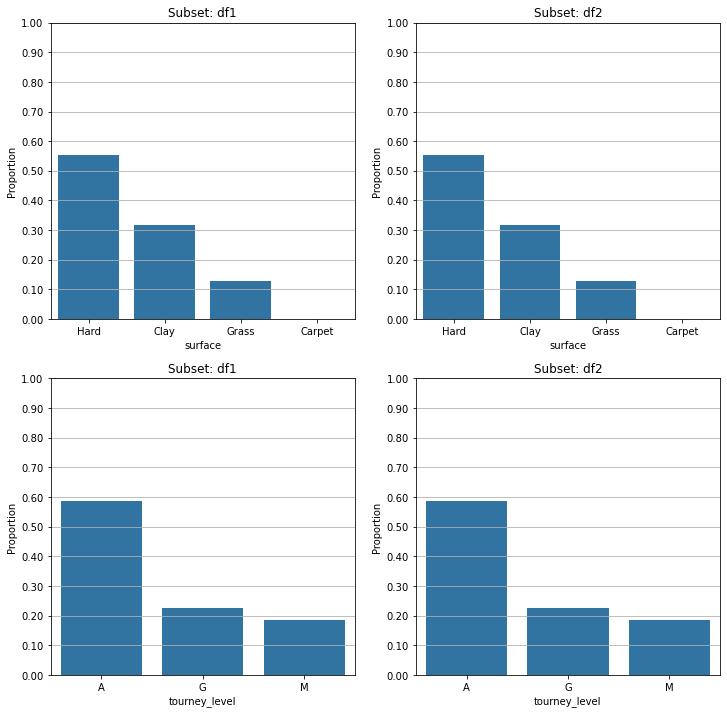

In [43]:
# столбцы и датафреймы для сравнения
subset_list = [df1, df2]
column_list = ['surface', 'tourney_level']

# сравним распределения между датафреймами
compare_distribution(subset_list, column_list)

#### 3.3.5.6 Create Match-specific Features

Необходимо учитывать значения обоих игроков для каждой фичи. Мы делаем это, принимая во внимание различия в фичах игроков, и, следовательно, получаем один набор фич, характерных для матча.

In [44]:
# колонки для удаления
columns_drop = ['tourney_id_per', 'round', 'hth_id', 'hth_id_match', 'tourney_date', 'winner_id', 
                'loser_id', 'winner_rank', 'loser_rank', 'winner_age', 'loser_age', 'winner_ht', 'loser_ht', 
                'winner_winrate', 'loser_winrate', 'winner_winrate_10', 'loser_winrate_10', 'winner_winrate_surf', 
                'loser_winrate_surf', 'winner_winrate_level', 'loser_winrate_level', 'w_round_avg_level', 'l_round_avg_level', 'w_round_avg_tid', 'l_round_avg_tid']

In [45]:
# посчитаем фичи для датафрейма1 
df1['rank_diff'] = df1['winner_rank'] - df1['loser_rank']
df1['age_diff'] = df1['winner_age'] - df1['loser_age']
df1['height_diff'] = df1['winner_ht'] - df1['loser_ht']

# фичи винрейта 
df1['winrate_diff'] = df1['winner_winrate'] - df1['loser_winrate']
df1['winrate_diff_10'] = df1['winner_winrate_10'] - df1['loser_winrate_10']
df1['winrate_diff_surf'] = df1['winner_winrate_surf'] - df1['loser_winrate_surf']
df1['winrate_diff_level'] = df1['winner_winrate_level'] - df1['loser_winrate_level']

# фичи раунда 
df1['round_avg_level'] = df1['w_round_avg_level'] - df1['l_round_avg_level']
df1['round_avg_tid'] = df1['w_round_avg_tid'] - df1['l_round_avg_tid']

# фичи hth
df1['hth_rate'] = df1['hth_rate']
df1['hth_rate_5'] = df1['hth_rate_5']

# таргет
df1['player_1_win'] = 1

# удаление колонок
df1.drop(columns_drop, axis=1, inplace=True)

# результат
df1.head()

,tourney_id,tourney_year,match_num,surface,tourney_level,hth_rate,hth_rate_5,rank_diff,age_diff,height_diff,winrate_diff,winrate_diff_10,winrate_diff_surf,winrate_diff_level,round_avg_level,round_avg_tid,player_1_win
0,2008-891,2008,1,Hard,A,0.0,0.0,-121.0,-1.25,2.0,0.2540,0.3,0.2091,0.2705,4.566860,3.625000,1
2,2008-891,2008,3,Hard,A,0.0,0.0,-97.0,-2.94,5.0,-0.0367,0.2,-0.1629,0.0260,0.678992,4.500000,1
4,2008-891,2008,5,Hard,A,0.0,0.0,-108.0,8.73,2.0,0.1751,0.1,0.0727,0.4086,2.021670,4.250000,1
6,2008-891,2008,7,Hard,A,0.0,0.0,-32.0,0.64,-3.0,0.0014,0.2,0.0408,0.0089,0.932382,0.480769,1
8,2008-891,2008,9,Hard,A,0.0,0.0,-42.0,1.86,-7.0,-0.0161,0.0,-0.0541,0.0800,1.138889,1.138889,1


In [46]:
# посчитаем фичи для датафрейма2
df2['rank_diff'] = df2['loser_rank'] - df2['winner_rank']
df2['age_diff'] = df2['loser_age'] - df2['winner_age']
df2['height_diff'] = df2['loser_ht'] - df2['winner_ht']

#  фичи винрейта
df2['winrate_diff'] = df2['loser_winrate'] - df2['winner_winrate']
df2['winrate_diff_10'] = df2['loser_winrate_10'] - df2['winner_winrate_10']
df2['winrate_diff_surf'] = df2['loser_winrate_surf'] - df2['winner_winrate_surf']
df2['winrate_diff_level'] = df2['loser_winrate_level'] - df2['winner_winrate_level']

# фичи раунда 
df2['round_avg_level'] = df2['l_round_avg_level'] - df2['w_round_avg_level']
df2['round_avg_tid'] = df2['l_round_avg_tid'] - df2['w_round_avg_tid']

# фичи hth
df2['hth_rate'] = df2['hth_rate']*(-1)
df2['hth_rate_5'] = df2['hth_rate_5']*(-1)

# таргет
df2['player_1_win'] = 0

# удаляем колонки
df2.drop(columns_drop, axis=1, inplace=True)

# результат
df2.head()

,tourney_id,tourney_year,match_num,surface,tourney_level,hth_rate,hth_rate_5,rank_diff,age_diff,height_diff,winrate_diff,winrate_diff_10,winrate_diff_surf,winrate_diff_level,round_avg_level,round_avg_tid,player_1_win
1,2008-891,2008,2,Hard,A,-0.0,-0.0,-131.0,4.72,-5.0,0.0390,0.0,-0.0284,0.1833,0.388889,0.388889,0
3,2008-891,2008,4,Hard,A,-1.0,-1.0,260.0,-12.57,-5.0,-0.1701,0.3,-0.1565,-0.0105,-1.981481,-0.148148,0
5,2008-891,2008,6,Hard,A,-0.0,-0.0,23.0,2.07,5.0,-0.0688,0.2,-0.1969,0.0834,1.621849,2.257143,0
7,2008-891,2008,8,Hard,A,-1.0,-1.0,-28.0,5.23,-5.0,0.0511,0.1,0.0382,0.1266,0.559692,-1.500000,0
9,2008-891,2008,10,Hard,A,1.0,1.0,5.0,-2.80,8.0,0.0054,0.1,0.0505,-0.0698,-0.749300,-3.000000,0


In [47]:
# объединяем в один датасет
total = pd.concat([df1, df2])

# посмотрим как распределен таргет 
total.groupby('player_1_win').size()

player_1_win
0    22278
1    22279
dtype: int64

In [48]:
# среднее значение фич для таргета 
total.groupby('player_1_win').mean()

,tourney_year,match_num,hth_rate,hth_rate_5,rank_diff,age_diff,height_diff,winrate_diff,winrate_diff_10,winrate_diff_surf,winrate_diff_level,round_avg_level,round_avg_tid
player_1_win,,,,,,,,,,,,,
0,2012.789972,308.791723,-0.217614,-0.179908,98.686327,-0.212203,-0.513101,-0.045789,-0.050523,-0.053141,-0.049192,-0.793296,-0.837659
1,2012.789712,308.773194,0.236007,0.195969,-96.007092,0.223555,0.514849,0.044834,0.053170,0.052465,0.048357,0.756691,0.801749


In [49]:
# проверим, что нет пропущенных значений 
total.isna().sum().sum()

0

### 3.3.6 Feature Transformation
Вспомним про выбросы, нормализируем числовые переменные и преобразуем категориальные 

#### 3.3.6.1 Handle Outliers
Ниже я проверяю, как распределяются значения для всех числовых переменных. Если есть выбросы, важно знать, вызваны ли они плохим качеством данных или верны. Поскольку все пиковые значения, приведенные ниже, можно объяснить и они кажутся правильными, на этом этапе данные не были удалены. Подробная информация о каждой фичи:
- **rank**: Диапазон от -2000 до 2000. Поскольку лучший рейтинг - 1, а худший - около 2000, это вполне вероятно.
- **age**: Диапазон от -30 до 30. Поскольку самому молодому игроку 14 лет, а самому старшему 59, это вполне вероятно.
- **height**: Диапазон от -45 до 45. Поскольку самый низкий игрок - 145, а самый высокий - 208, это вполне вероятно.
- **head-to-head**: 
    - **hth**: Диапазон от -17 до 17. То, что игрок выиграл еще 17 матчей против того же игрока, вполне вероятно.
    - **hth_5**: Диапазон от -5 до 5. Имеет смысл, поскольку мы используем только 5 последних совпадений для этой функции.
- **winrate**: 
    - **winrate**: Диапазон от -0,8 до 0,8. Поскольку процент побед каждого игрока может быть от 0 до 1, это имеет смысл.
    - **winrate_10**: Диапазон от -1 до 1. Так как процент побед может быть от 0 до 1 для каждого игрока, это имеет смысл.
    - **winrate_surf**: Диапазон от -1 до 1. Так как процент побед может быть от 0 до 1 для каждого игрока, это имеет смысл.
    - **winrate_level**: Диапазон от -1 до 1. Так как процент побед может быть от 0 до 1 для каждого игрока, это имеет смысл.
- **round**: 
    - **round_avg_level**: Диапазон от -9 до 9. Так как лучший раунд - 11, а худший раунд - 1, это имеет смысл.
    - **round-avg_tid**: Диапазон от -10 до 10. Так как лучший раунд - 11, а худший раунд - 1, это имеет смысл.

In [50]:
def check_distribution(df, columns):
    '''
    гистограмма для каждого перечисленного столбца в датафрейме
    
    INPUT:
    (dataframe) df - pandas dataframe
    (list) columns - list of column names to be plotted
    
    OUTPUT:
    None
    '''
     
    row_size = 1
    column_size = len(columns)
    f_width = column_size*3
    f_height = 4
    plot_counter = 0

  
    fig = plt.figure(figsize = [f_width, f_height])

    # создадим 2 X column_size grid 
    gs = grd.GridSpec(2, column_size, height_ratios=[8,2], width_ratios=None, hspace=0.3, wspace=0.6)

    
    for column in columns:
        
        # найдём min и max для X 
        column_min = df[column].min()
        column_max = df[column].max()
        column_range = df[column].max() - df[column].min()
        min_x = df[column].min() - (column_range / 20)
        max_x = df[column].max() + (column_range / 20)
        
        # гистограмма
        ax = plt.subplot(gs[plot_counter])
        warnings.simplefilter('ignore') # ignore warning due to bug in distplot
        p = sns.distplot(df[column], kde=False, norm_hist=False)
        warnings.simplefilter('default')
        ax.xaxis.set_label_position('top') 
        if plot_counter == 0:
            plt.ylabel('Frequency')
        plt.xlim(min_x, max_x)

       
        ax2 = plt.subplot(gs[plot_counter + column_size])
        ax2.spines['right'].set_visible(False)
        ax2.spines['top'].set_visible(False)
        ax2.spines['left'].set_visible(False)
        ax2.spines['bottom'].set_visible(False)
        ax2 = sns.boxplot(x=df[column])
        plt.xlabel('age_diff')
        ax2.set(yticks=[])
        ax2.get_xaxis().set_visible(False)
        plt.xlim(min_x, max_x)
        
       
        plot_counter += 1

    
    plt.show()

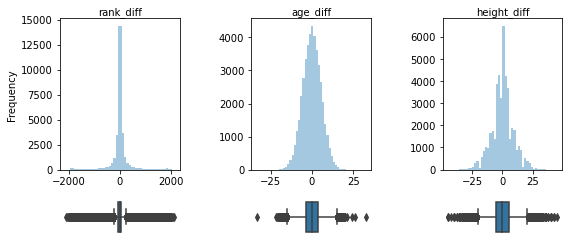

In [51]:
# посмотрим на распределение обычных фич 
check_distribution(total, ['rank_diff', 'age_diff', 'height_diff'])

C:\Users\admin\anaconda3\envs\gpu_env\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


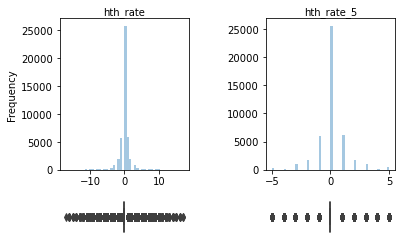

In [52]:
# посмотрим на распределение hth фич
check_distribution(total, ['hth_rate', 'hth_rate_5'])

C:\Users\admin\anaconda3\envs\gpu_env\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


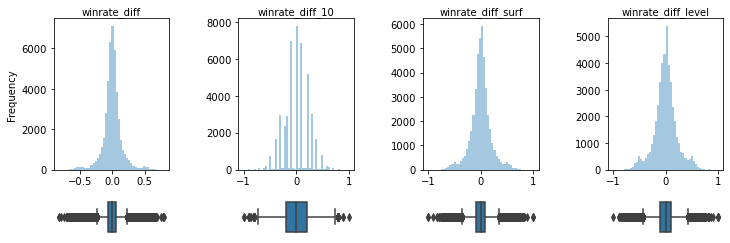

In [53]:
# посмотрим на распределение winrate фич
check_distribution(total, ['winrate_diff', 'winrate_diff_10', 'winrate_diff_surf', 'winrate_diff_level'])

C:\Users\admin\anaconda3\envs\gpu_env\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


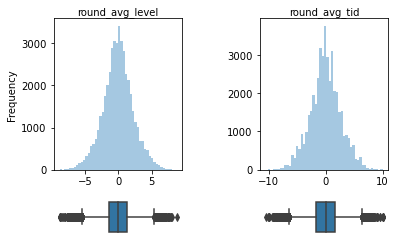

In [54]:
# посмотрим на распределение round фич
check_distribution(total, ['round_avg_level', 'round_avg_tid'])

#### 3.3.6.2 Normalize Numerical Features

In [55]:
# посмотрим на данные до скалирования 
total.head()

C:\Users\admin\anaconda3\envs\gpu_env\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,tourney_id,tourney_year,match_num,surface,tourney_level,hth_rate,hth_rate_5,rank_diff,age_diff,height_diff,winrate_diff,winrate_diff_10,winrate_diff_surf,winrate_diff_level,round_avg_level,round_avg_tid,player_1_win
0,2008-891,2008,1,Hard,A,0.0,0.0,-121.0,-1.25,2.0,0.2540,0.3,0.2091,0.2705,4.566860,3.625000,1
2,2008-891,2008,3,Hard,A,0.0,0.0,-97.0,-2.94,5.0,-0.0367,0.2,-0.1629,0.0260,0.678992,4.500000,1
4,2008-891,2008,5,Hard,A,0.0,0.0,-108.0,8.73,2.0,0.1751,0.1,0.0727,0.4086,2.021670,4.250000,1
6,2008-891,2008,7,Hard,A,0.0,0.0,-32.0,0.64,-3.0,0.0014,0.2,0.0408,0.0089,0.932382,0.480769,1
8,2008-891,2008,9,Hard,A,0.0,0.0,-42.0,1.86,-7.0,-0.0161,0.0,-0.0541,0.0800,1.138889,1.138889,1


In [56]:
# инициализируем скалер
scaler = MinMaxScaler(feature_range=(0, 1))
numerical = ['hth_rate', 'hth_rate_5', 'rank_diff', 'age_diff', 'height_diff', 'winrate_diff', 'winrate_diff_10', 'winrate_diff_surf', 'winrate_diff_level', 'round_avg_level', 'round_avg_tid']

# применяем скалер
total_norm = pd.DataFrame(data = total)
total_norm[numerical] = scaler.fit_transform(total[numerical])

# посмотрим на отскалированные данные 
display(total_norm.head(n = 5))

C:\Users\admin\anaconda3\envs\gpu_env\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,tourney_id,tourney_year,match_num,surface,tourney_level,hth_rate,hth_rate_5,rank_diff,age_diff,height_diff,winrate_diff,winrate_diff_10,winrate_diff_surf,winrate_diff_level,round_avg_level,round_avg_tid,player_1_win
0,2008-891,2008,1,Hard,A,0.5,0.5,0.471654,0.488291,0.522222,0.664475,0.65,0.60455,0.63525,0.761026,0.689865,1
2,2008-891,2008,3,Hard,A,0.5,0.5,0.477299,0.462591,0.555556,0.485835,0.60,0.41855,0.51300,0.540120,0.732432,1
4,2008-891,2008,5,Hard,A,0.5,0.5,0.474712,0.640055,0.522222,0.615990,0.55,0.53635,0.70430,0.616410,0.720270,1
6,2008-891,2008,7,Hard,A,0.5,0.5,0.492590,0.517032,0.466667,0.509248,0.60,0.52040,0.50445,0.554517,0.536902,1
8,2008-891,2008,9,Hard,A,0.5,0.5,0.490238,0.535584,0.422222,0.498494,0.50,0.47295,0.54000,0.566251,0.568919,1


In [57]:
# убедимся что значения находятся в диапазоне от 0 до 1 
total_norm.describe()

C:\Users\admin\anaconda3\envs\gpu_env\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,tourney_year,match_num,hth_rate,hth_rate_5,rank_diff,age_diff,height_diff,winrate_diff,winrate_diff_10,winrate_diff_surf,winrate_diff_level,round_avg_level,round_avg_tid,player_1_win
count,44557.000000,44557.000000,44557.000000,44557.000000,44557.000000,44557.000000,44557.000000,44557.000000,44557.000000,44557.000000,44557.000000,44557.000000,44557.000000,44557.000000
mean,2012.789842,308.782458,0.500271,0.500803,0.500432,0.507386,0.500010,0.508095,0.500662,0.499832,0.499792,0.500501,0.512641,0.500011
std,3.099055,310.697241,0.046798,0.124853,0.085383,0.084323,0.098920,0.088687,0.117038,0.093821,0.106589,0.126825,0.127286,0.500006
min,2008.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2010.000000,23.000000,0.500000,0.500000,0.487415,0.451034,0.444444,0.472009,0.400000,0.456100,0.446400,0.423542,0.434054,0.000000
50%,2013.000000,220.000000,0.500000,0.500000,0.500353,0.507299,0.500000,0.508204,0.500000,0.500000,0.500000,0.501540,0.513514,1.000000
75%,2015.000000,708.000000,0.500000,0.500000,0.513291,0.564173,0.555556,0.543969,0.600000,0.544100,0.553150,0.578122,0.589740,1.000000
max,2018.000000,946.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### 3.3.6.3 Categorical Variables
тут я воспользуюсь dummy кодированием 

In [58]:
# создадим dummy переменные 
total_final = pd.get_dummies(total_norm, columns=['surface', 'tourney_level'], dummy_na=False, prefix_sep='_')
total_final.head()

C:\Users\admin\anaconda3\envs\gpu_env\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,tourney_id,tourney_year,match_num,hth_rate,hth_rate_5,rank_diff,age_diff,height_diff,winrate_diff,winrate_diff_10,winrate_diff_surf,winrate_diff_level,round_avg_level,round_avg_tid,player_1_win,surface_Carpet,surface_Clay,surface_Grass,surface_Hard,tourney_level_A,tourney_level_G,tourney_level_M
0,2008-891,2008,1,0.5,0.5,0.471654,0.488291,0.522222,0.664475,0.65,0.60455,0.63525,0.761026,0.689865,1,0,0,0,1,1,0,0
2,2008-891,2008,3,0.5,0.5,0.477299,0.462591,0.555556,0.485835,0.60,0.41855,0.51300,0.540120,0.732432,1,0,0,0,1,1,0,0
4,2008-891,2008,5,0.5,0.5,0.474712,0.640055,0.522222,0.615990,0.55,0.53635,0.70430,0.616410,0.720270,1,0,0,0,1,1,0,0
6,2008-891,2008,7,0.5,0.5,0.492590,0.517032,0.466667,0.509248,0.60,0.52040,0.50445,0.554517,0.536902,1,0,0,0,1,1,0,0
8,2008-891,2008,9,0.5,0.5,0.490238,0.535584,0.422222,0.498494,0.50,0.47295,0.54000,0.566251,0.568919,1,0,0,0,1,1,0,0


----
# 4. Modeling

## 4.1 Benchmark Prediction

In [59]:
# посчитаем 
all_matches = len(atp_2018_df)
correct_matches = len(atp_2018_df[atp_2018_df['winner_rank'] < atp_2018_df['loser_rank']])
benchmark_accuracy = round(100 * correct_matches / all_matches, 1)

# результат
print('Benchmark prediction: {} of {} correct - {}%'.format(correct_matches, all_matches, benchmark_accuracy))

Benchmark prediction: 1661 of 2622 correct - 63.3%


C:\Users\admin\anaconda3\envs\gpu_env\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## 4.2 Machine Learning Prediction

### 4.3.1 Modeling Technique
Проверим, насколько хорошо разные модели могут предсказывать исход теннисных матчей. Поскольку результат теннисного матча известен и есть два игрока и только один победитель, это проблема бинарной классификации, в которой мы можем использовать  обучение с учителем. Я буду оценивать следующие классификаторы:
- Logistic Regression
- Gaussian Naive Bayes
- Random Forest
- XGBoost

### 4.3.2 Metric Chosen

Ранее при подготовке данных мы убедились, что в 50% данных игрок 1 является победителем, а в 50% - игрок 2 победитель. Поскольку распределение классификации сбалансировано, мы будем использовать **accuracy** в качестве метрики для оценки производительности модели. Аccuracy определяет, как часто классификатор делает правильный прогноз.Рассчитывается следующим образом:

- Число правильных предсказаний / число всех предсказаний 

### 4.3.3 Shuffle and Split Data

#### 4.3.3.1 Validate Data
Сохраним Validate, данные которые будут использованы для предсказаний потом.

In [77]:
# для validate используем данные за 2018 год 
validate = total_final[total_final['tourney_year'] == 2018].copy()



# перемешаем данные 
validate = validate.sample(frac=1.0, random_state=42).reset_index(drop=True)

# разделим данные на фичи и таргет
y_validate = validate['player_1_win']
X_validate = validate.drop(['player_1_win', 'tourney_id', 'match_num', 'tourney_year'], axis = 1)

# проверим размерности 
print('Shape of X_validate: {}'.format(X_validate.shape))
print('Shape of y_validatee: {}'.format(y_validate.shape))


validate.groupby('tourney_year').size().to_frame()

Shape of X_validate: (3934, 18)
Shape of y_validatee: (3934,)


C:\Users\admin\anaconda3\envs\gpu_env\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,0
tourney_year,
2018,3934


In [78]:
print("validate set has an average of {} for y.".format(round(y_challenge.mean(), 4)))

validate set has an average of 0.5 for y.


C:\Users\admin\anaconda3\envs\gpu_env\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### 4.3.3.2 Train and Test Data

In [63]:
# уберём данные за последний год 
train_test = total_final[total_final['tourney_year'] < 2018].copy()

# перемешаем данные 
train_test = train_test.sample(frac=1.0, random_state=42).reset_index(drop=True)

# разделим на фичи и таргет
y = train_test['player_1_win']
X = train_test.drop(['player_1_win', 'tourney_id', 'match_num', 'tourney_year'], axis = 1)


print('Shape of X: {}'.format(X.shape))
print('Shape of y: {}'.format(y.shape))


train_test.groupby('tourney_year').size().to_frame()

Shape of X: (40623, 18)
Shape of y: (40623,)


C:\Users\admin\anaconda3\envs\gpu_env\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,0
tourney_year,
2008,4167
2009,4326
2010,4316
2011,4259
2012,4269
2013,4304
2014,4228
2015,4268
2016,3868


In [64]:
# разделим данные на тестовую и тренировочную выборки 
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.2, 
                                                    random_state = 42)


print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 32498 samples.
Testing set has 8125 samples.


C:\Users\admin\anaconda3\envs\gpu_env\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [65]:
print("Training set has an average of {} for y.".format(round(y_train.mean(), 4)))
print("Testing set has an average of {} for y.".format(round(y_test.mean(), 4)))

Training set has an average of 0.4985 for y.
Testing set has an average of 0.5062 for y.


### 4.3.4 Training and Predicting Pipeline
Creating a pipeline that can be reused later.

In [66]:
def train_predict(learner, X_train, y_train, X_test, y_test): 
    '''
    
    INPUT:
    (clf) learner - the learning algorithm to be trained and predicted on
    (dataframe) X_train - features training set
    (dataframe) y_train - target training set
    (dataframe) X_test - features testing set
    (dataframe) y_test - target testing set
    
    OUTPUT:
    (dict) results - results from training and testing 
    '''
    
    # словарь для результатов 
    results = {}
    
    # обучаем модель на train данных
    start = time() # Get start time
    learner = learner.fit(X_train, y_train)
    end = time() # Get end time
    
    
        
    
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train)
    
            
    # считаем accuracy на train 
    results['acc_train'] = round(accuracy_score(y_train, predictions_train), 4)
        
    # считаем accuracy на test 
    results['acc_test'] = round(accuracy_score(y_test, predictions_test), 4)
     
    
    return results

### 4.3.5 Feature Selection
Посмотрим на сколько хорошо фичи помогают на предсказывать результат, поэтому воспользуемся логистической регрессией, те фичи, которые показывают результат меньше 50 % на тесте отбросим 

In [67]:
LR_model = LogisticRegression(solver='lbfgs', random_state=42, max_iter=200)

# получаем результат для каждой колонки 
results = {}
for column in X_train.columns:
    results[column] = train_predict(LR_model, X_train[column].values.reshape(-1, 1), y_train, X_test[column].values.reshape(-1, 1), y_test)

# результаты 
results_df = pd.DataFrame(results)
results_df.T.sort_values('acc_test', ascending=[False])

,acc_train,acc_test
rank_diff,0.6723,0.6642
round_avg_level,0.6547,0.6431
winrate_diff,0.6403,0.6326
round_avg_tid,0.6409,0.6309
winrate_diff_surf,0.6320,0.6271
winrate_diff_level,0.6064,0.6144
winrate_diff_10,0.5927,0.5927
hth_rate_5,0.5454,0.5457
hth_rate,0.5454,0.5455
height_diff,0.5146,0.5154


In [68]:
# создадим список лучших фич 
best_features = ['rank_diff', 'round_avg_level', 'round_avg_tid', 'winrate_diff', 'winrate_diff_surf', 'winrate_diff_level', 'winrate_diff_10', 'height_diff', 'hth_rate_5', 'hth_rate', 'age_diff']

C:\Users\admin\anaconda3\envs\gpu_env\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### 4.3.6 Initial Model Evaluation
Я использовал четыре модели машинного обучения, все они были обучены, а потом показали результаты на test выборке.Сначала они обучались на всех фичах, а потом на тех , которые мы выбрали выше. Я заметил следующее:
- XGBClassifier предсказывает лучше, чем остальные классификаторы
- При обучении на выбранных фичах я не ощутил сильной разницы по сравнению с полным датасетом фич 
- RandomForestClassifer явно переобучился.
- XGB и random forest выбираются для дальнейшого улучшения. Также будем использовать все фичи.

#### 4.3.6.1 All Features
Обучимся на всех фичах

In [69]:
# модели 
clf_LR = LogisticRegression(solver='lbfgs', random_state=42, max_iter=200)
clf_GNB = GaussianNB()
clf_RF = RandomForestClassifier(n_estimators=10, random_state=42)
clf_XGB = xgb.XGBClassifier(objective ='reg:logistic', colsample_bytree = 0.3, learning_rate = 0.1,
                            max_depth = 5, alpha = 10, n_estimators = 10, random_state=42)

# собираем результаты в датафрейм
results = {}
for clf in [clf_LR, clf_GNB, clf_RF, clf_XGB]:
    clf_name = clf.__class__.__name__
    results[clf_name] = train_predict(clf, X_train, y_train, X_test, y_test)

# отображение результатов 
results_df = pd.DataFrame(results)
results_df

C:\Users\admin\anaconda3\envs\gpu_env\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


,LogisticRegression,GaussianNB,RandomForestClassifier,XGBClassifier
acc_train,0.6863,0.6714,0.9858,0.7098
acc_test,0.6738,0.6618,0.6751,0.6902


#### 4.3.6.2 Selected Features
Обучимся на выбранных фичах.

In [70]:
# модели 
clf_LR_SF = LogisticRegression(solver='lbfgs', random_state=42, max_iter=200)
clf_GNB_SF = GaussianNB()
clf_RF_SF = RandomForestClassifier(n_estimators=10, random_state=42)
clf_XGB_SF = xgb.XGBClassifier(objective ='reg:logistic', colsample_bytree = 0.3, learning_rate = 0.1,
                          max_depth = 5, alpha = 10, n_estimators = 10)

# собираем результаты в датафрейм
results = {}
for clf in [clf_LR_SF, clf_GNB_SF, clf_RF_SF, clf_XGB_SF]:
    clf_name = clf.__class__.__name__
    results[clf_name] = train_predict(clf, X_train[best_features], y_train, X_test[best_features], y_test)

# отображение результатов
results_df = pd.DataFrame(results)
results_df

C:\Users\admin\anaconda3\envs\gpu_env\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\admin\anaconda3\envs\gpu_env\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


,LogisticRegression,GaussianNB,RandomForestClassifier,XGBClassifier
acc_train,0.6862,0.6707,0.9854,0.7118
acc_test,0.6745,0.6613,0.6724,0.6954


### 4.3.7 Model Tuning
XGBoost was the best based on the tuning:
- Random Forest got 69.40% accuracy on test data
- XGBoost got 74.07% accuracy on test data

#### 4.3.7.1 Random Forest

In [71]:
# инициализируем случайный лес
RF_clf = RandomForestClassifier(n_estimators=10, random_state=42, n_jobs=-1)

# параметры для тюнинга модели
parameters = {'n_estimators': [16, 18, 20], 
              'max_depth': [10, 12, 14], 
              'min_samples_leaf': [2, 4, 6], 
              'min_samples_split': [14, 16, 18]}

# создадим объект accuracy_score используя make_scorer()
scorer = make_scorer(accuracy_score)

# воспользуемся GridSearchCV для выбора оптимальных параметров
grid_obj = GridSearchCV(RF_clf, parameters, cv=5, scoring=scorer, verbose=4, n_jobs=-1)


grid_fit = grid_obj.fit(X_train, y_train)

# получим лучшее значение
best_RF_clf = grid_fit.best_estimator_

# сделаем предсказания с помощью дефолтной модели и модели, после GridSearchCV
predictions = (RF_clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_RF_clf.predict(X_test)


print("Unoptimized model: Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("Optimized Model: Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))

C:\Users\admin\anaconda3\envs\gpu_env\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Fitting 5 folds for each of 81 candidates, totalling 405 fits
Unoptimized model: Accuracy score on testing data: 0.6751
Optimized Model: Final accuracy score on the testing data: 0.6940


In [72]:
best_RF_clf

C:\Users\admin\anaconda3\envs\gpu_env\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


RandomForestClassifier(max_depth=12, min_samples_leaf=2, min_samples_split=14,
                       n_estimators=20, n_jobs=-1, random_state=42)

#### 4.3.7.2 XGBoost

In [73]:
# инициализируем XGBoost
XGB_clf = xgb.XGBClassifier(objective ='reg:logistic', colsample_bytree = 0.3, learning_rate = 0.1,
                          max_depth = 5, alpha = 10, n_estimators = 10, n_jobs=-1, random_state=42)

# параметры для тюнинга модели
parameters = {'learning_rate': [0.7, 0.75, 0.8],
              'max_depth': [5, 6, 7],
              'n_estimators': [11, 12, 13],
              'subsample': [0.9, 0.95, 1],
              'colsample_bytree': [0.70, 0.75, 0.80],
              'alpha': [1, 2, 3]
             }

# создадим объект accuracy_score используя make_scorer()
scorer = make_scorer(accuracy_score)

# воспользуемся GridSearchCV для выбора оптимальных параметров
grid_obj = GridSearchCV(XGB_clf, parameters, cv=5, scoring=scorer, verbose=4, n_jobs=-1)

grid_fit = grid_obj.fit(X_train, y_train)

# получим лучшее значение
best_XGB_clf = grid_fit.best_estimator_

# сделаем предсказания с помощью дефолтной модели и модели, после GridSearchCV
predictions = (XGB_clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_XGB_clf.predict(X_test)


print("Unoptimized model: Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("Optimized Model: Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))

Fitting 5 folds for each of 729 candidates, totalling 3645 fits


C:\Users\admin\anaconda3\envs\gpu_env\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Unoptimized model: Accuracy score on testing data: 0.6902
Optimized Model: Final accuracy score on the testing data: 0.7407


In [74]:
# параметры для лучшей модели 
best_XGB_clf

C:\Users\admin\anaconda3\envs\gpu_env\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


XGBClassifier(alpha=1, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.7, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=13, n_jobs=-1, num_parallel_tree=1,
              objective='reg:logistic', random_state=42, reg_alpha=1,
              reg_lambda=1, scale_pos_weight=1, subsample=0.95,
              tree_method='exact', validate_parameters=1, verbosity=None)

### 4.3.8 Feature Importance

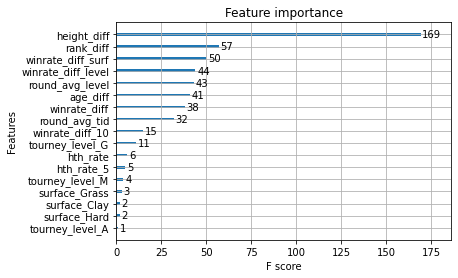

In [75]:
ax = xgb.plot_importance(best_XGB_clf)

### 4.3.9 Predict on validate

In [79]:
def predict_validate(learner, X_validate, y_validate): 
    '''
    
    INPUT:
    (clf) learner - the learning algorithm to use for prediction
    (dataframe) X_validate - features validate set
    (dataframe) y_cvalidate - target validate set
    
    OUTPUT:
    (dict) results - results from training and testing
    '''
    
    
    results = {}
            
    pred_validate = learner.predict(X_validate)
    results['predictions'] = pred_validate
   
    results['acc_validate'] = round(accuracy_score(y_validate, pred_validate), 4)
        
    return results

In [81]:
results = {}
for clf in [clf_LR, clf_GNB, best_RF_clf, best_XGB_clf]:
    clf_name = clf.__class__.__name__
    results[clf_name] = predict_validate(clf, X_validate, y_validate)


results_df = pd.DataFrame(results).T
results_df['acc_validate'].to_frame().sort_values(['acc_validate'], ascending=[False])

,acc_validate
XGBClassifier,0.8457
RandomForestClassifier,0.7064
LogisticRegression,0.6355
GaussianNB,0.6146


In [82]:
# собираем данные в один датафрейм
validate_pred_df = pd.DataFrame()
validate_pred_df['Actual'] = y_validate
validate_pred_df['Predicted'] = results_df['predictions']['XGBClassifier']
validate_pred_df['Correct'] = np.where(validate_pred_df['Actual'] == validate_pred_df['Predicted'], 1, 0)

# считаем результат
all_model = len(validate_pred_df)
correct_model = validate_pred_df['Correct'].sum()
model_accuracy = round(100 * correct_model / all_model, 1)


print('Model prediction: {} of {} correct - {}%'.format(correct_model, all_model, model_accuracy))

Model prediction: 3327 of 3934 correct - 84.6%


C:\Users\admin\anaconda3\envs\gpu_env\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


----
# 5. Evaluation

In [83]:
# Подготавливаем данные для визуализации
data = {'classifier': ['Machine Learning Model', 'Benchmark'], 
        'accuracy': [model_accuracy, benchmark_accuracy]}
pred_df = pd.DataFrame(data)
pred_df

C:\Users\admin\anaconda3\envs\gpu_env\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,classifier,accuracy
0,Machine Learning Model,84.6
1,Benchmark,63.3


C:\Users\admin\anaconda3\envs\gpu_env\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\admin\anaconda3\envs\gpu_env\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


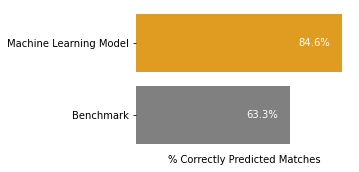

In [84]:
colors = ['grey' if (x < max(pred_df['accuracy'])) else 'orange' for x in pred_df['accuracy']]
plt.figure(figsize = (3,2))
ax = plt.axes([0,0,1,1], frameon=False)
ax = sns.barplot(pred_df.accuracy, pred_df.classifier, palette = colors)
ax.set(xlabel='% Correctly Predicted Matches', ylabel='')
ax.get_xaxis().set_ticks([])

# добавим анотации 
locs, labels = plt.yticks() 

for y_loc, label in zip(locs, labels):

    pct = pred_df.loc[y_loc, 'accuracy']
    pct_string = '{}%'.format(pct)

    ax.text(pct-18, y_loc, pct_string, va= 'center', color = 'white', weight='normal')